In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import faiss

features_path = Path("data") / "features"

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30764\3544797485.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import numpy as np
import pandas as pd

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list).astype(np.float32) # (n_images, 1024)
np.save(Path("data") / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids.to_csv(Path("data") / "photo_ids.csv", index=False)

In [4]:
n, d = features.shape # n: number of images, d: dimension of each image feature
index = faiss.IndexFlatIP(d) # build the index
index.add(features) # add vectors to the index

In [5]:
print(f"The index contains {index.ntotal} vectors.")

The index contains 14892 vectors.


In [6]:
index_npy_path = "index_features.index"
faiss.write_index(index, index_npy_path)

## Load CLIP

In [1]:
from app.load_clip import load_clip_model
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = load_clip_model("finetuned_RN50.pt")

c:\Users\LENOVO\Documents\Github\CS336.O11.KHCL\.venv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Load dataset

In [12]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

val_dataset_path = Path("splited_fashionIQ") / "val"

val_images_files = list(val_dataset_path.glob("*.png"))

print(f"Val images found: {len(val_images_files)}")

Val images found: 14892


In [13]:
# Load the query image
query_path = val_dataset_path / "245600258X.png"

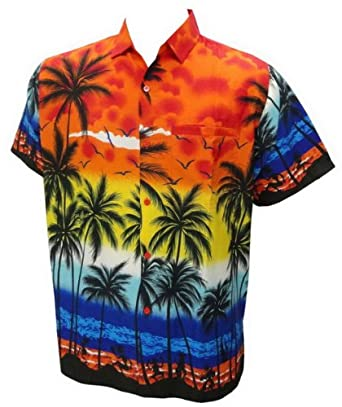

In [14]:
Image.open(query_path)

In [15]:
def extract_query_features(query_path):
    query = Image.open(query_path)

    query_preprocessed = preprocess(query).unsqueeze(0).to(device)

    with torch.no_grad():
        query_features = model.encode_image(query_preprocessed)
        query_features /= query_features.norm(dim=-1, keepdim=True)

    return query_features.cpu().numpy()

In [16]:
query_features = extract_query_features(query_path)

In [17]:
# index = faiss.read_index("index_features.index")

distances, indices = index.search(query_features, k=5)

# `I` contains the indices of the top 5 most similar images
print("Indices of the top 5 most similar images:", indices)

Indices of the top 5 most similar images: [[    0 13273 14288  1459 13092]]


In [23]:
photo_ids.iloc[indices[0]].values[0]

array(['245600258X'], dtype=object)

Top 1 image name: 245600258X
Top 1 cosine sim: -2.384185791015625e-07


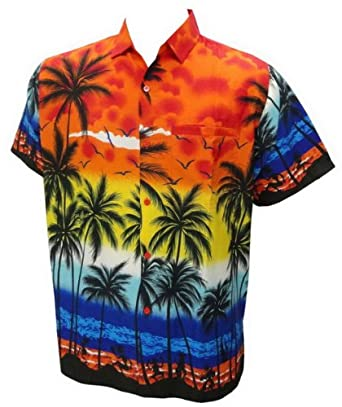

Top 2 image name: B00CVT3DD4
Top 2 cosine sim: 0.07663559913635254


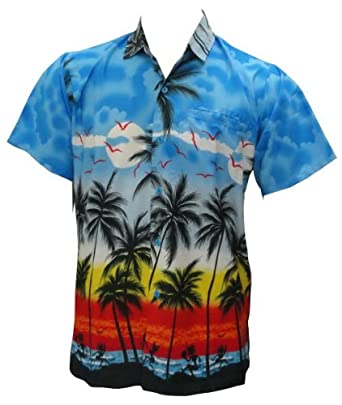

Top 3 image name: B00EFZ786K
Top 3 cosine sim: 0.09326416254043579


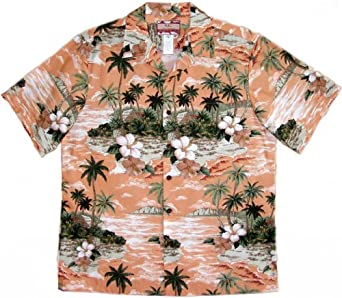

Top 4 image name: B002UCR85G
Top 4 cosine sim: 0.09802031517028809


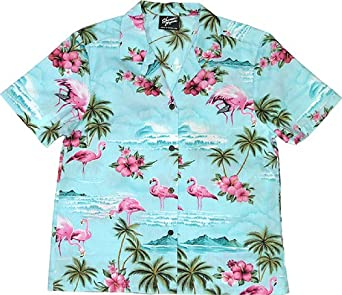

Top 5 image name: B00CO5FLLW
Top 5 cosine sim: 0.09928703308105469


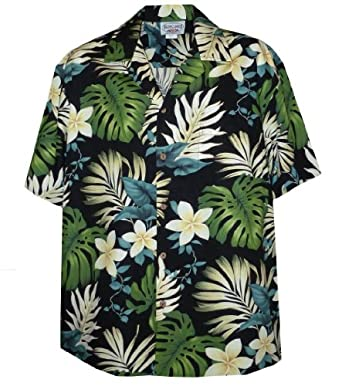

In [29]:
from IPython.display import display

for i, idx in enumerate(indices[0]):
    print(f"Top {i+1} image name: {photo_ids.iloc[idx].values[0]}")
    print(f"Top {i+1} cosine sim: {1 - distances[0][i]}")
    filename = photo_ids.iloc[idx].values[0] + ".png"
    display(Image.open(val_dataset_path / filename))